In [2]:
from google.colab import files
from google.colab import drive
import os

# optional: mount Google Drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/w207/
!ls

[Errno 2] No such file or directory: '/content/gdrive/My Drive/w207/'
/content
gdrive	sample_data


In [4]:
!pip install python-resize-image

In [5]:
pip install git+https://github.com/Soongja/basic-image-eda

  Cloning https://github.com/Soongja/basic-image-eda to /tmp/pip-req-build-kk91fgx5
  Running command git clone -q https://github.com/Soongja/basic-image-eda /tmp/pip-req-build-kk91fgx5
  Created wheel for basic-image-eda: filename=basic_image_eda-0.0.3-cp36-none-any.whl size=9699 sha256=3c3b0901eb7ff7a263abf68ee07f8cc5e33b6cd7e820c665cd92c9166ce16ed4
  Stored in directory: /tmp/pip-ephem-wheel-cache-yt2y4f1l/wheels/99/9a/62/b1003b6a2487fe73d57ccee8081ccacf9ab06ea9f8ddda770c
Successfully built basic-image-eda


In [6]:
import pandas as pd
import numpy as np
import matplotlib as plt
from pylab import *
from PIL import Image
from resizeimage import resizeimage
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from basic_image_eda import BasicImageEDA

Using TensorFlow backend.


In [7]:
train_csv=pd.read_csv('/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv')

# Distributions of Training Data

Benign vs Malignant

In [8]:
print("Of {} samples, {:.1%} are benign and {:.1%} are malignant.\n".format(
    train_csv.shape[0],
    train_csv[train_csv.benign_malignant == 'benign'].shape[0]/train_csv.shape[0],
    train_csv[train_csv.benign_malignant == 'malignant'].shape[0]/train_csv.shape[0]))

pd.DataFrame(train_csv.benign_malignant.value_counts())

Of 33126 samples, 98.2% are benign and 1.8% are malignant.



,benign_malignant
benign,32542
malignant,584


Total Samples vs Distinct Samples

The 33126 samples in training data only consist of 2056 unique patients. Each patient averages 16.1 samples.


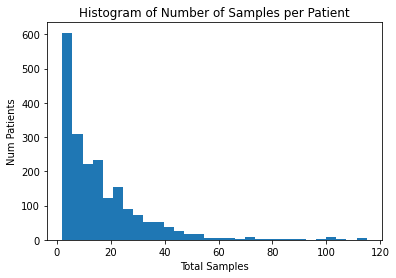

In [9]:
num_uniques = train_csv.patient_id.nunique()

print("The {} samples in training data only consist of {} unique patients.\
 Each patient averages {:.1f} samples.".format(
     train_csv.shape[0], num_uniques, train_csv.shape[0]/num_uniques))
gender_value_count_table = train_csv.patient_id.value_counts()

plt.hist(gender_value_count_table, bins = 30)
plt.title('Histogram of Number of Samples per Patient')
plt.ylabel('Num Patients')
plt.xlabel('Total Samples')
plt.show()

Male to Female Ratio

Of 33126 samples, 51.6% are male samples, 48.2% female samples. Of 2056 unique patients, 52.4% are male, 47.5% female.

        Count_All_Samples
male                17080
female              15981
NaN                    65


        Count_Unique_Patients
male                     1077
female                    977
NaN                         2




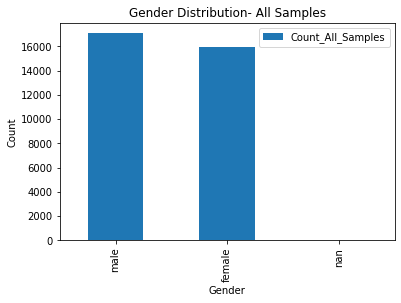

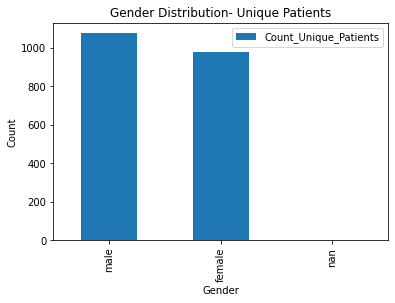

In [10]:
train_csv_unique_patients = train_csv.drop_duplicates(subset='patient_id', keep="first")

gender_table_all_samples = pd.DataFrame(train_csv.sex.value_counts(dropna = False)).rename(
    columns = {'sex': 'Count_All_Samples'})

gender_table_unique_patients = pd.DataFrame(train_csv_unique_patients.sex.value_counts(dropna = False)).rename(
    columns = {'sex': 'Count_Unique_Patients'})


print("Of {} samples, {:.1%} are male samples, {:.1%} female samples. Of {} unique patients,\
 {:.1%} are male, {:.1%} female.\n".format(train_csv.shape[0],gender_table_all_samples.loc['male'][0]/train_csv.shape[0],
                                           gender_table_all_samples.loc['female'][0]/train_csv.shape[0],
                                           train_csv_unique_patients.shape[0],
                                           gender_table_unique_patients.loc['male'][0]/train_csv_unique_patients.shape[0],
                                           gender_table_unique_patients.loc['female'][0]/train_csv_unique_patients.shape[0]))

print(gender_table_all_samples)
print("\n")
print(gender_table_unique_patients)
print("\n")

gender_table_all_samples.plot(kind = 'bar', title= 'Gender Distribution- All Samples')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

gender_table_unique_patients.plot(kind = 'bar', title= 'Gender Distribution- Unique Patients')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

Age and Length of Treatment

The mean age of patient at the time of sample is 48.9. The mean length of treatment is 3.7.


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


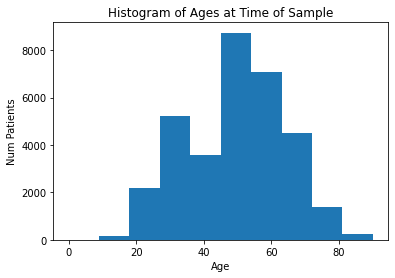

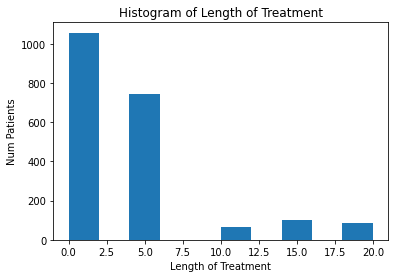

In [11]:
patient_max_min_ages = train_csv.groupby(by = ['patient_id']).agg({'age_approx' : [np.min, np.max]})
patient_treatment_length = patient_max_min_ages.age_approx.amax - patient_max_min_ages.age_approx.amin

print("The mean age of patient at the time of sample is {:.1f}. The mean length of treatment is {:.1f}.".format(
    train_csv.age_approx.mean(), patient_treatment_length.mean()))

plt.hist(train_csv.age_approx)
plt.title('Histogram of Ages at Time of Sample')
plt.ylabel('Num Patients')
plt.xlabel('Age')
plt.show()

plt.hist(patient_treatment_length)
plt.title('Histogram of Length of Treatment')
plt.ylabel('Num Patients')
plt.xlabel('Length of Treatment')
plt.show()

Location on the Body

In [12]:
train_csv

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


Images are most commonly taken from the torso 50.9%, lower extremity 25.4%, or upper extremity 15.0%.


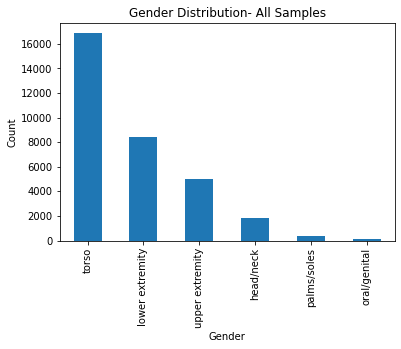

In [13]:
anatomy_table = train_csv.anatom_site_general_challenge.value_counts()


print("Images are most commonly taken from the torso {:.1%}, lower extremity {:.1%}, or \
upper extremity {:.1%}.".format(anatomy_table.loc['torso']/train_csv.shape[0],
                            anatomy_table.loc['lower extremity']/train_csv.shape[0],
                            anatomy_table.loc['upper extremity']/train_csv.shape[0]))

anatomy_table.plot(kind = 'bar', title= 'Gender Distribution- All Samples')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()